In [30]:
from math import pi

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.linalg as LA

import matplotlib.pyplot as plt



# 1 Rotation

## 1.1 Your answer here

1.2.a your answer here

1.2.b your answer here

1.2.c

In [2]:
# Note Matplotlib is only suitable for simple 3D visualization.
# For later problems, you should not use Matplotlib to do the plotting

def show_points(points):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[0], points[2], points[1])
    
def compare_points(points1, points2):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[0], points1[2], points1[1])
    ax.scatter(points2[0], points2[2], points2[1])    

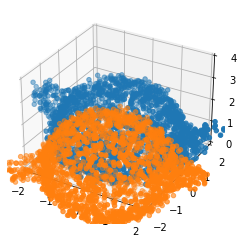

In [3]:
npz = np.load('data/HW1_P1.npz')
X = npz['X']
Y = npz['Y']
compare_points(X, Y)  # noisy teapotsand

In [4]:
# copy-paste your hw0 solve module here
def hw0_solve(A, b, eps):
    x = np.zeros(A.shape[1])
    return x

In [5]:
R1 = np.eye(3)
# solve this problem here, and store your final results in R1
for __ in range(100):
    pass

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

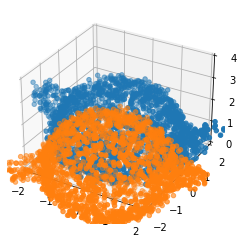

In [6]:
# Testing code, you should see the points of the 2 teapots roughly overlap
compare_points(R1@X, Y)
R1.T@R1

1.4.a your solution here

1.4.b your solution here

# 2 Geometry

2.1 your solution here

In [7]:
a, b, c = 1, 1, 0.5

In [8]:
# These are some convenient functions to create open3d geometries and plot them
# The viewing direction is fine-tuned for this problem, you should not change them
import open3d
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1e-4, 1))
    view_ctl.set_front((0, 0.5, 2))
    view_ctl.set_lookat((0, 0, 0))
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img)[::-1, ::-1])
    for g in geoms:
        vis.remove_geometry(g)
    
def create_arrow_from_vector(origin, vector):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(0.05, 0.1, 0.25, 0.2)
    arrow.paint_uniform_color([1,0,1])
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

def create_ellipsoid(a,b,c):
    sphere = open3d.geometry.TriangleMesh.create_sphere()
    sphere.transform(np.diag([a,b,c,1]))
    sphere.compute_vertex_normals()
    return sphere


def create_lines(points):
    lines = []
    for p1, p2 in zip(points[:-1], points[1:]):
        height = np.linalg.norm(p2-p1)
        center = (p1+p2) / 2
        d = p2-p1
        d /= np.linalg.norm(d)
        axis = np.cross(np.array([0,0,1]), d)
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.array([0,0,1]) @ d)
        R = open3d.geometry.get_rotation_matrix_from_axis_angle(axis * angle)
        
        T = np.eye(4)
        T[:3,:3]=R
        T[:3,3] = center
        cylinder = open3d.geometry.TriangleMesh.create_cylinder(0.02, height)
        cylinder.transform(T)
        cylinder.paint_uniform_color([1,0,0])
        lines.append(cylinder)
    return lines

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
# exapmle code to draw ellipsoid, curve, and arrows
arrow = create_arrow_from_vector([0.,0.,1.], [1.,1.,0.])
ellipsoid = create_ellipsoid(a, b, c)
cf = open3d.geometry.TriangleMesh.create_coordinate_frame()
cf.scale(1.5, (0,0,0))
curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
# draw_geometries([ellipsoid, cf, arrow] + curve)
geoms = [ellipsoid, cf, arrow] + curve


In [10]:
def f(u, v):
    """
    map from point in domian \in R2 to surface R3
    """
    assert -pi < u < pi
    assert 0 < v < pi

    a, b, c = 1, 1, 0.5
    f = np.array([a * np.cos(u) * np.sin(v), b * np.sin(u) * np.sin(v), c * np.cos(v)])
    return f


def D_fp(u, v):
    """
    differential (Jacobian)
    a linear map
    """
    a, b, c = 1, 1, 0.5
    return np.array(
        [
            [-a * np.sin(u) * np.sin(v), a * np.cos(u) * np.cos(v)],
            [b * np.cos(u) * np.sin(v), b * np.sin(u) * np.cos(v)],
            [0, -c * np.sin(v)],
        ]
    )


def gamma(t):
    u = pi / 4
    v = pi / 6
    return t + u, v


## 2.2 

In [11]:
p0 = np.array([pi/4, pi/6])
    
ts = np.arange(0, 1, 0.01)
gamma_t = np.array([gamma(t) for t in ts])

curve2D =  np.vstack([p0, gamma_t])

f_curve3D = np.asarray([f(u, v) for u, v in curve2D])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(f_curve3D)

# add point cloud to geoms
geoms.append(pcd)
plt.show()
geoms.pop()
# keep geoms reusable.

PointCloud with 101 points.

### 2.3.a 
What is $Df_p$? Express it as a matrix.

In [12]:
def Df_p(u, v):
    """
    Df_p: T_p(R^2) -> T_{f(p)}R^3
    """
    a, b, c = 1, 1, 0.5
    return np.array(
        [
            [-a * np.sin(u) * np.sin(v), a * np.cos(u) * np.cos(v)],
            [b * np.cos(u) * np.sin(v), b * np.sin(u) * np.cos(v)],
            [0, -c * np.sin(v)],
        ]
    )


### 2.3.b
Describe the geometric meaning of $Df_p$

It maps or relate a vector in tangent space ($T_{p}$) of the domain $U$ to the tangent space of the surface $T_{f(p)}$.


2.3.c

In [32]:
epslion = 0.5

X = np.array([1, 0])

delta_fp = epslion * D_fp(X[0], X[1]) @ (X.reshape(-1, 1))
delta_fp

array([[0.],
       [0.],
       [0.]])

In [27]:

delta_fp = epslion * D_fp(X[0], X[1]) @ (X.reshape(-1, 1))
delta_fp

array([[-0.        ,  0.54030231],
       [ 0.        ,  0.84147098],
       [ 0.        , -0.        ]])

2.3.d

2.3.e

2.4.a

2.4.b

2.4.c

2.5.a

2.5.b

2.5.c

2.5.d

# 3 Mesh

3.1 your proof here

3.2 your proof here

3.3 your solution here

In [14]:
# You may want to restart your notebook here, to reinitialize Open3D

import open3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

# Make sure you call this function to draw the points for proper viewing direction
def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1, 0))
    view_ctl.set_front((0, 2, 1))
    view_ctl.set_lookat((0, 0, 0))
    view_ctl.set_zoom(1)
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img))
    for g in geoms:
        vis.remove_geometry(g)

In [15]:
import trimesh
mesh = trimesh.load('sievert.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(mesh.vertices)
draw_geometries([pcd])
plt.title("Sievert's surface")

ModuleNotFoundError: No module named 'trimesh'

3.4

# 4 Point Cloud

4.1 your solution here

4.2 your solution here

4.3 your solution here

4.4 your solution here

# 5 Course Feedback